In [1]:
# first read the models 
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import os
import codecs
import random
import copy
import matplotlib.pyplot as plt
#plt.rcParams["figure.figsize"] = [8, 10]
import numpy as np
from collections import defaultdict 
torch.set_num_threads(8)
torch.manual_seed(1)
random.seed(1)

In [2]:
nitrofilepath = './best_models/'
model_names = ['2deep_bilstm_best_model_epoch_'+str(i)+'.model' for i in xrange(6)]

In [3]:
# First load the data, don't change this 
# -*- coding: utf-8 -*-
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import random
torch.set_num_threads(8)
import sys
import codecs
import random
import torch.utils.data as Data
import copy

SEED = 1
random.seed(SEED)


# input: a sequence of tokens, and a token_to_index dictionary
# output: a LongTensor variable to encode the sequence of idxs
def prepare_sequence(seq, to_ix, cuda=False):
    var = autograd.Variable(torch.LongTensor([to_ix[w] for w in seq.split(' ')]))
    return var

def prepare_label(label,label_to_ix, cuda=False):
    var = autograd.Variable(torch.LongTensor([label_to_ix[label]]))
    return var

def build_token_to_ix(sentences):
    token_to_ix = dict()
    print(len(sentences))
    for sent in sentences:
        for token in sent.split(' '):
            if token not in token_to_ix:
                token_to_ix[token] = len(token_to_ix)
    token_to_ix['<pad>'] = len(token_to_ix)
    return token_to_ix

def build_label_to_ix(labels):
    label_to_ix = dict()
    for label in labels:
        if label not in label_to_ix:
            label_to_ix[label] = len(label_to_ix)


def get_all_files_from_dir(dirpath):
    from os import listdir
    from os.path import isfile, join
    onlyfiles = [f for f in listdir(dirpath) if isfile(join(dirpath, f))]
    return onlyfiles

def head_n(fname, n=2):
    count = 1
    print ('---------------------------------------')
    f = open(fname)
    for line in f:
        print (line)
        count += 1
        if count > n:
            print ('-----------------------------------')
            f.close()
            return
#head_n(test_file_pos,10)
#thos function would only extract vp and vn files, in order to extract vpn = vp+vn in one file, give last arguement as False/0 

def extract_names(l_files,patt,p_xor_n = True):
    # note that you may need to 
    r = []
    for f in l_files:
        tokens = f.split(".")
        if tokens[-3]==patt:
            if p_xor_n:
                if tokens[-2] != 'vpn':
                    r.append(f)
                    #yield f
            elif tokens[-2] == 'vpn':
                return f
    return sorted(r)
#extract_names(files,'test')
def get_sentence_out(path):
    f = open(path)
    return map(lambda x:x.split(",")[2],f)
def get_neg_pos_sent(type_,files,path):
    return [get_sentence_out(path+n) for n in extract_names(files,type_)]
def load_stanford_data():
    fpath = './cross_validation_data/vpn_filtered/'
    files = get_all_files_from_dir(fpath)
    
    train_sent_neg,train_sent_pos = get_neg_pos_sent('train',files,fpath)
    val_sent_neg,val_sent_pos = get_neg_pos_sent('dev',files,fpath)
    test_sent_neg,test_sent_pos = get_neg_pos_sent('test',files,fpath)
    
    train_data = [(sent,1) for sent in train_sent_pos] + [(sent, 0) for sent in train_sent_neg]
    dev_data = [(sent, 1) for sent in val_sent_pos] + [(sent, 0) for sent in val_sent_neg]
    test_data = [(sent, 1) for sent in test_sent_pos] + [(sent, 0) for sent in test_sent_neg]
    
    random.shuffle(train_data)
    random.shuffle(dev_data)
    random.shuffle(test_data)

    print('train:',len(train_data),'dev:',len(dev_data),'test:',len(test_data))
    
    word_to_ix = build_token_to_ix([s for s,_ in train_data+dev_data+test_data])
    label_to_ix = {0:0,1:1}
    print('vocab size:',len(word_to_ix),'label size:',len(label_to_ix))
    print('loading data done!')
    return train_data,dev_data,test_data,word_to_ix,label_to_ix
train_data, dev_data, test_data, word_to_ix, label_to_ix = load_stanford_data()
EMBEDDING_DIM = 100
HIDDEN_DIM = 100
EPOCH = 20
NUM_LAYERS = 2
loss_function = nn.NLLLoss()#negative log likelihood loss 
########################################################################################


#Define the BiLSTM class################################################################

class BiLSTMClassifier(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, num_layers, vocab_size, label_size):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim,num_layers,bidirectional=True)
        self.hidden2label = nn.Linear(2*hidden_dim, label_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # the first is the hidden h
        # the second is the cell  c
        return (autograd.Variable(torch.zeros(self.num_layers*2, 1, self.hidden_dim)),
                autograd.Variable(torch.zeros(self.num_layers*2, 1, self.hidden_dim)))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        x = embeds.view(len(sentence), 1, -1)
        lstm_out, self.hidden = self.lstm(x, self.hidden)
        y  = self.hidden2label(lstm_out[-1])
        log_probs = F.log_softmax(y)
        return log_probs

('train:', 25667, 'dev:', 292, 'test:', 657)
26616
('vocab size:', 14378, 'label size:', 2)
loading data done!


In [4]:
#ok, hardcode a sentence and see what happens to it
#train_data[0]
#s,true_label = (u'there ought to be a directing license , so that ed burns can have his revoked . ',0)
#s,true_label = ('this is a bad movie',0)
#s,true_label = ('this is a good movie',1)
#s,true_label = ('great direction but ok movie',1)
#print s,true_label
#sent = data_loader.prepare_sequence(s, word_to_ix)
#label = data_loader.prepare_label(label, label_to_ix)

In [5]:
# load models
lms = {}
for n in model_names:
    key_name = nitrofilepath+n
    lms[key_name]=torch.load(key_name)

lms.keys()

['./best_models/2deep_bilstm_best_model_epoch_5.model',
 './best_models/2deep_bilstm_best_model_epoch_3.model',
 './best_models/2deep_bilstm_best_model_epoch_4.model',
 './best_models/2deep_bilstm_best_model_epoch_1.model',
 './best_models/2deep_bilstm_best_model_epoch_0.model',
 './best_models/2deep_bilstm_best_model_epoch_2.model']

In [6]:
def derivative_embedding(x,m):
        loss_function = nn.NLLLoss()#negative log likelihood loss 
        lstm_out, _ = m.lstm(x, m.hidden)
        y  = m.hidden2label(lstm_out[-1])
        log_probs = F.log_softmax(y)
        a =log_probs.data.max(1)[1]
        pred_label = autograd.Variable(torch.LongTensor(a))
        loss = loss_function(log_probs, pred_label)
        #print loss
        m.zero_grad()
        loss.backward(retain_graph=True)
        return float(x.grad.view(1,-1).norm(2,dim=1))

In [7]:
def draw_model(loded_model_states,s,label,plt):
    decode = {0: 'Negative',1:'Positive'}
    print s
    string = 'true label:'+decode[label]+'\t'+'predicted label:'
    sent = prepare_sequence(s, word_to_ix)
    label = prepare_label(label, label_to_ix)
    # check what model predicts about this sentence 
    grads = []
    model =BiLSTMClassifier(embedding_dim=EMBEDDING_DIM,hidden_dim=HIDDEN_DIM, num_layers = NUM_LAYERS,
                           vocab_size=len(word_to_ix),label_size=len(label_to_ix))
    for i in xrange(len(sent)):
        model.load_state_dict(copy.deepcopy(loded_model_states))
        # first, get a single embedding of a single word 
        x = autograd.Variable(torch.zeros(1,1, EMBEDDING_DIM),requires_grad=True)
        for j in xrange(EMBEDDING_DIM):
                x.data[0,0,j]=model.word_embeddings(sent).view(len(sent), 1, -1).data[i,0,j]
        result = derivative_embedding(x,model)
        grads.append(result)
    y = s.split(" ")[::-1]
    y_pos = np.arange(len(y))*15
    plt.barh(y_pos, grads[::-1],10, align='center', alpha=0.4)
    plt.yticks(y_pos, y)
    log_probs = model.forward(sent)
    a =log_probs.data.max(1)[1]
    string += decode[int(a)]
    print string+'\n'
    return plt


In [8]:
epoch_models = sorted(lms.keys())

In [9]:
tries = [('this is a bad movie',0),('this is a good movie',1),('good direction but average movie',1)]

Epoch1
this is a bad movie


/home/dharashah/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/home/dharashah/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:143: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


true label:Negative	predicted label:Positive



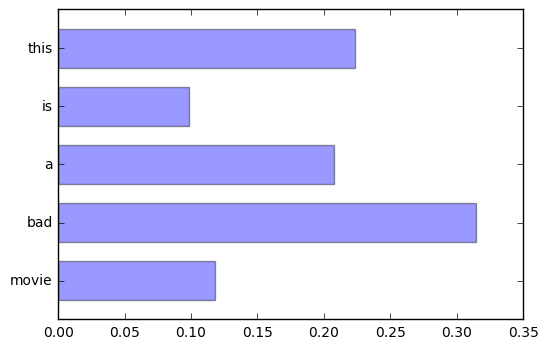

Epoch2
this is a bad movie
true label:Negative	predicted label:Positive



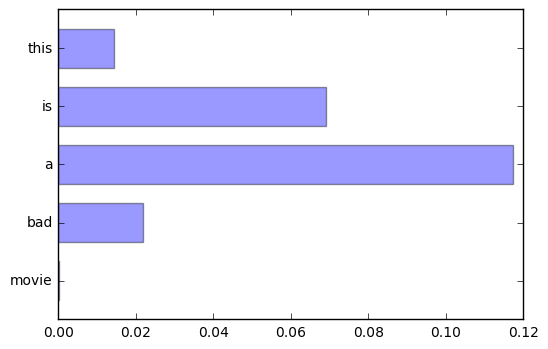

Epoch3
this is a bad movie
true label:Negative	predicted label:Negative



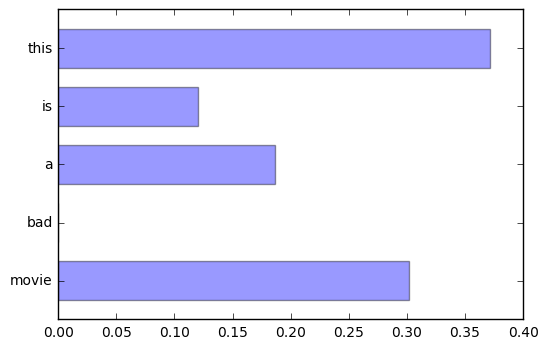

Epoch4
this is a bad movie
true label:Negative	predicted label:Negative



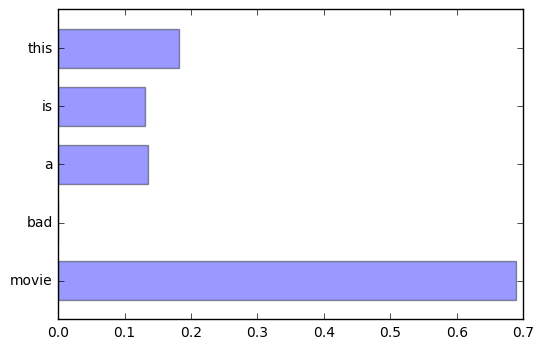

Epoch1
this is a good movie
true label:Positive	predicted label:Negative



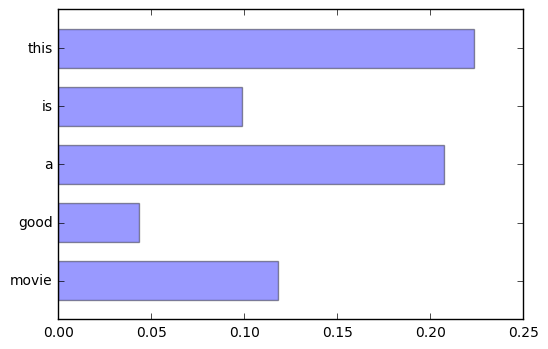

Epoch2
this is a good movie
true label:Positive	predicted label:Positive



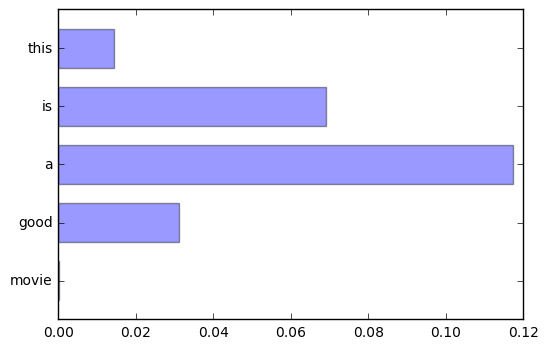

Epoch3
this is a good movie
true label:Positive	predicted label:Positive



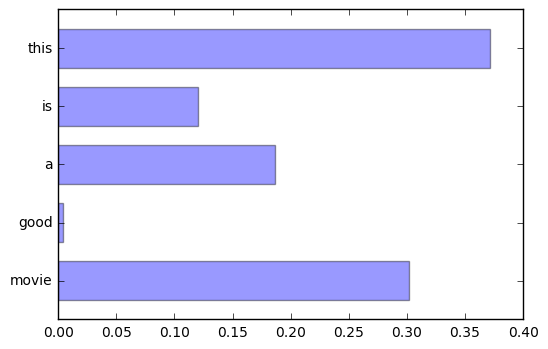

Epoch4
this is a good movie
true label:Positive	predicted label:Positive



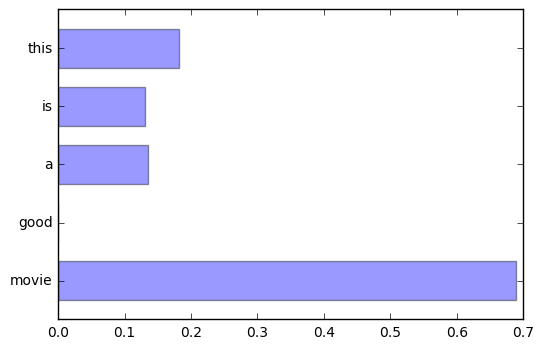

Epoch1
good direction but average movie
true label:Positive	predicted label:Negative



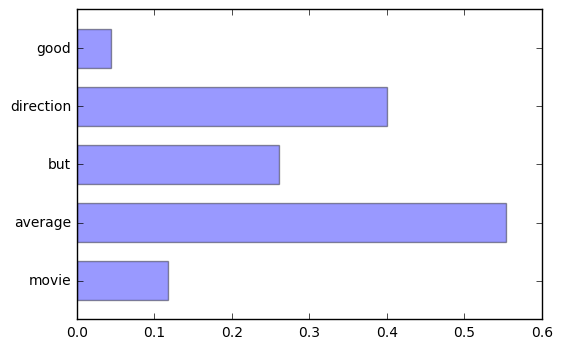

Epoch2
good direction but average movie
true label:Positive	predicted label:Negative



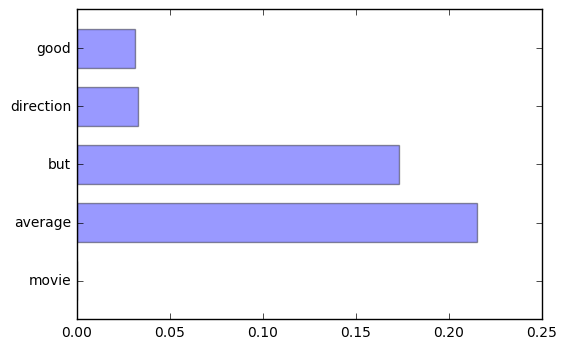

Epoch3
good direction but average movie
true label:Positive	predicted label:Positive



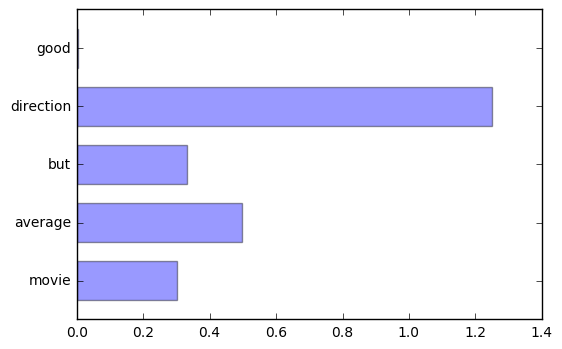

Epoch4
good direction but average movie
true label:Positive	predicted label:Positive



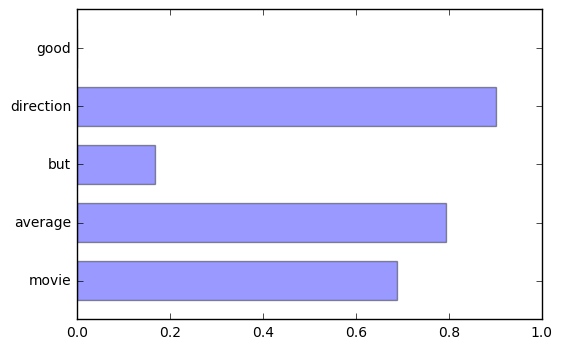

In [11]:
import matplotlib.pyplot as plt
for s, true_label in tries:
    for i,m in enumerate(epoch_models[:4]):
        print 'Epoch'+str(i+1)
        plt0 = draw_model(lms[m],s,true_label,plt)
        plt0.show()